# Assignment #4: Decision Trees, Boosting, Bagging 

## Loading the Dataset

In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

sns.set_theme()

In [77]:
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165)  
# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features 
y = concrete_compressive_strength.data.targets 

In [78]:
X.head() 

Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   

   Coarse Aggregate  Fine Aggregate  Age  
0            1040.0           676.0   28  
1            1055.0           676.0   28  
2             932.0           594.0  270  
3             932.0           594.0  365  
4             978.4           825.5  360

In [79]:
y.head()

Concrete compressive strength
0                          79.99
1                          61.89
2                          40.27
3                          41.05
4                          44.30

In [80]:
features=list(concrete_compressive_strength.variables['name'][:-1])

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Decision Tree

### Selecting Best Method for max_feature selection

In [82]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse.mean()

def  max_features_methods_plot(methods_list, scores_list):
    # Plotting
    if methods_list[0]==None:
        methods_list[0]='auto'
    plt.bar(methods_list, scores_list)
    plt.xlabel('Method for max_features')
    plt.ylabel('RMSE')
    plt.title('RMSE scores for different methods of selecting max_features')
    plt.show()



In [83]:
# Testing different values for max_features
scores_list=[]
methods=[None, 'sqrt', 'log2']
for method in methods:
    dt = DecisionTreeRegressor(max_features=method, random_state=42)
    score = rmse_cv(dt, X_train, y_train)
    scores_list.append(score)

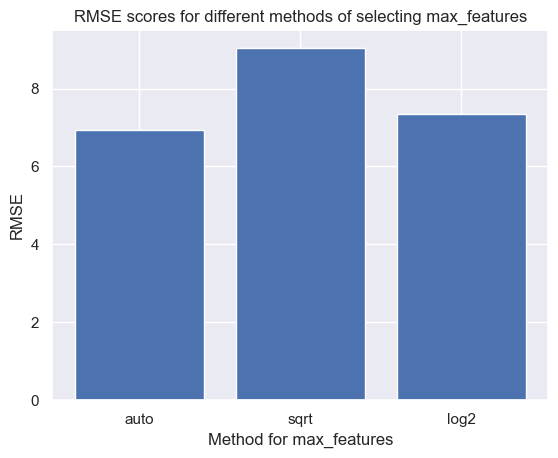

In [84]:
max_features_methods_plot(methods,scores_list)

### Cost Complexiity Pruning

In [85]:
# Define parameter grid for grid search
param_grid = {'ccp_alpha': np.linspace(0, 1, 20)}

# Initialize DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42, max_features=None)

# Perform grid search with 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=kf, scoring=make_scorer(mean_squared_error, greater_is_better=False))
grid_search.fit(X_train, y_train)

# Get the best parameters
best_alpha = grid_search.best_params_['ccp_alpha']


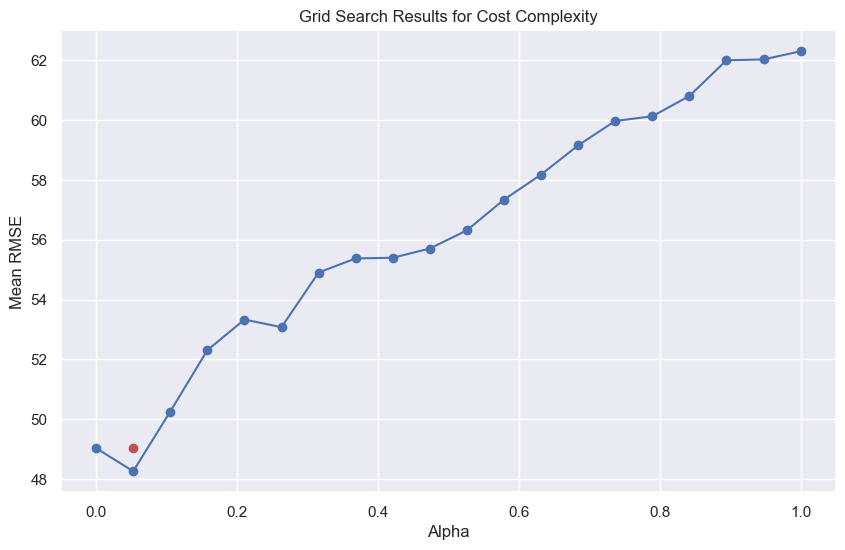

In [86]:
alphas = grid_search.cv_results_['param_ccp_alpha'].data
means = grid_search.cv_results_['mean_test_score']

# Plot grid search results
plt.figure(figsize=(10, 6))
plt.plot(alphas, -means, marker='o')
plt.title('Grid Search Results for Cost Complexity')
plt.scatter(best_alpha, -means[0], color='r', label=f'Best Alpha ({best_alpha:.2f})')  # Highlight best alpha in red
plt.xlabel('Alpha')
plt.ylabel('Mean RMSE')
plt.grid(True)
plt.show()

### Plotting the Best Tree

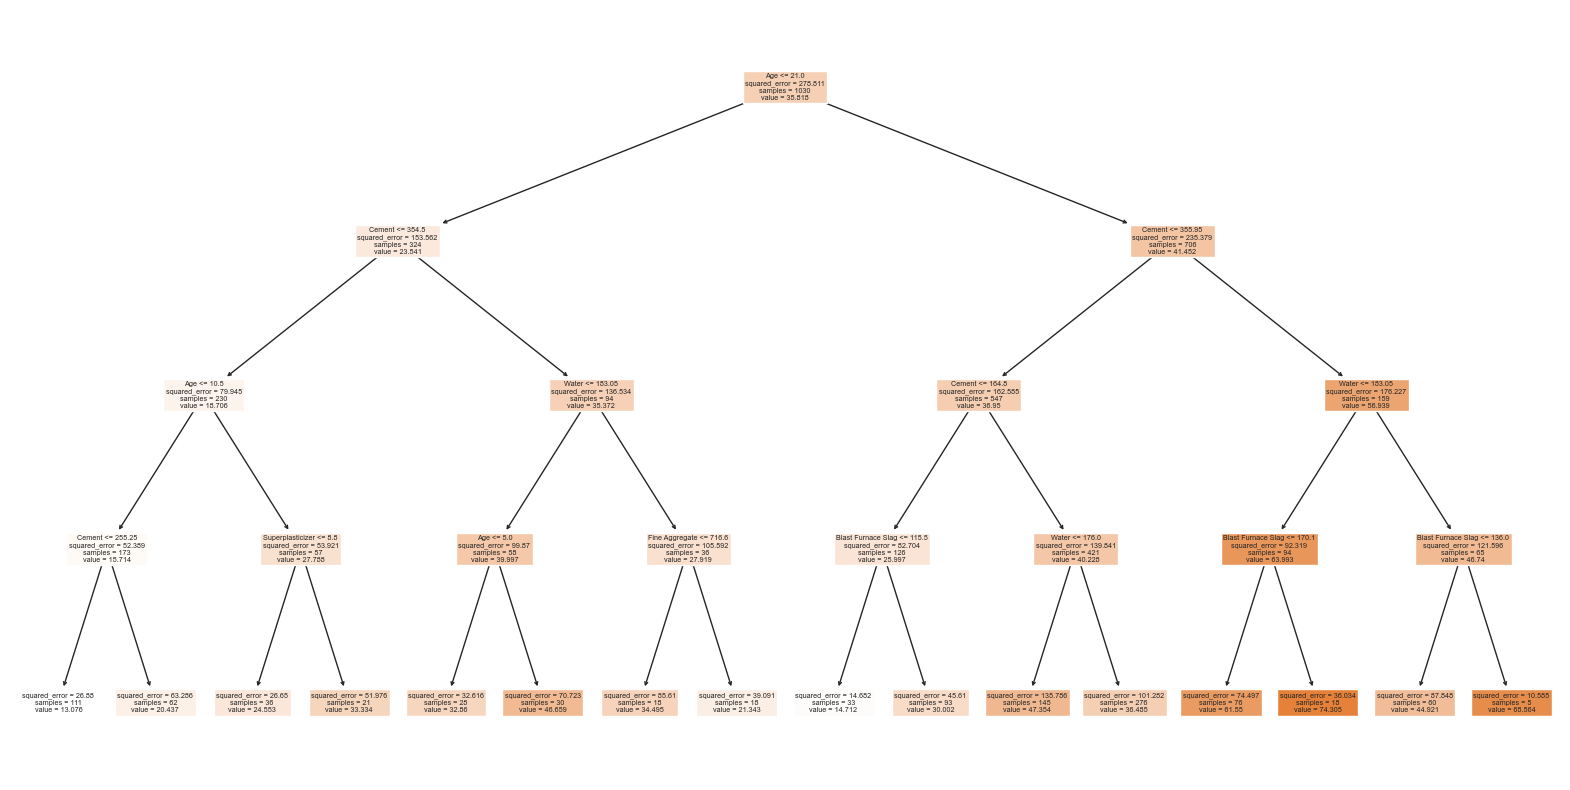

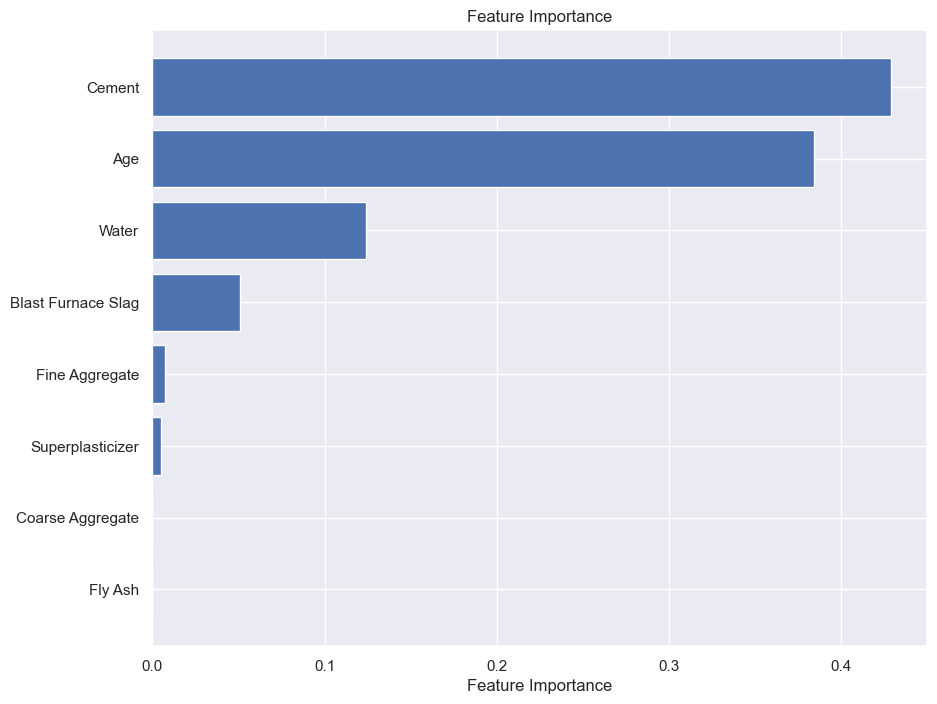

In [87]:
# Plot the best tree
dt = DecisionTreeRegressor(max_depth=4, max_features=None, ccp_alpha=best_alpha, random_state=42)
dt.fit(X, y)
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X.columns)
plt.show()

# Feature importance
importance = dt.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importance)
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()


### Performance of Test Data

In [88]:
y_hat=dt.predict(X_test)
DT_rmse=round(np.sqrt(mean_squared_error(y_test,y_hat)), 4)
DT_rmse

8.9116

## Random Forest

In [89]:
methods[0]=None
methods

[None, 'sqrt', 'log2']

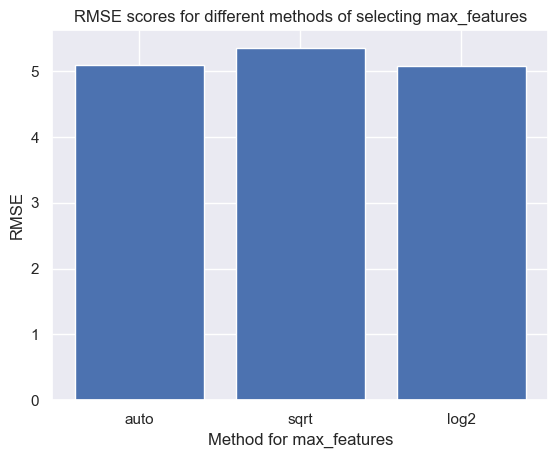

In [90]:
Y=np.ravel(y)
rf_scores=[]
for method in methods:
    # Initialize Random Forest with current max_features method
    rf = RandomForestRegressor(max_features=method, random_state=42)
    rf_score = rmse_cv(rf, X, Y)
    rf_scores.append(rf_score)
    
max_features_methods_plot(methods, rf_scores)


In [91]:
np.argmin(rf_scores )

2

### Max_Depth values Grid Search

In [92]:
param_grid_rf = {
    'n_estimators': range(1, 101)  # Example values for max_depth
}
rf = RandomForestRegressor(random_state=42, max_features='log2')

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=kf, scoring=make_scorer(mean_squared_error, greater_is_better=False))
grid_search_rf.fit(X, Y)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(max_features='log2',
                                             random_state=42),
             param_grid={'n_estimators': range(1, 101)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'))

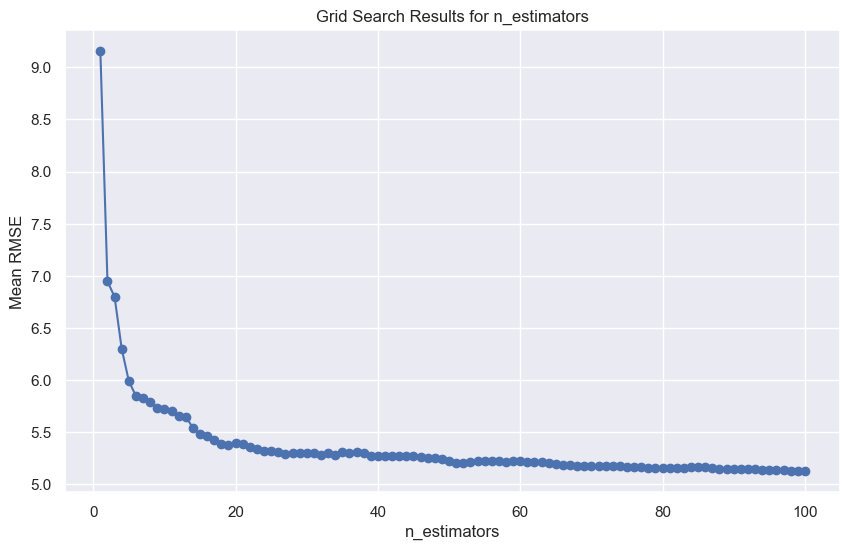

In [93]:
mean_test_scores = grid_search_rf.cv_results_['mean_test_score']
param_values = param_grid_rf['n_estimators']
best_n=param_values[np.argmax(mean_test_scores)]

# Plot the mean test scores
plt.figure(figsize=(10, 6))
plt.plot(param_values, np.sqrt(-mean_test_scores), marker='o')
plt.title('Grid Search Results for n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Mean RMSE')
plt.grid(True)
plt.show()

In [94]:
#Final model fitting
rf = RandomForestRegressor(random_state=42, max_features='log2', n_estimators=best_n)
rf.fit(X_train, y_train)

/Users/synergy/anaconda3/envs/MLPython/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_features='log2', random_state=42)

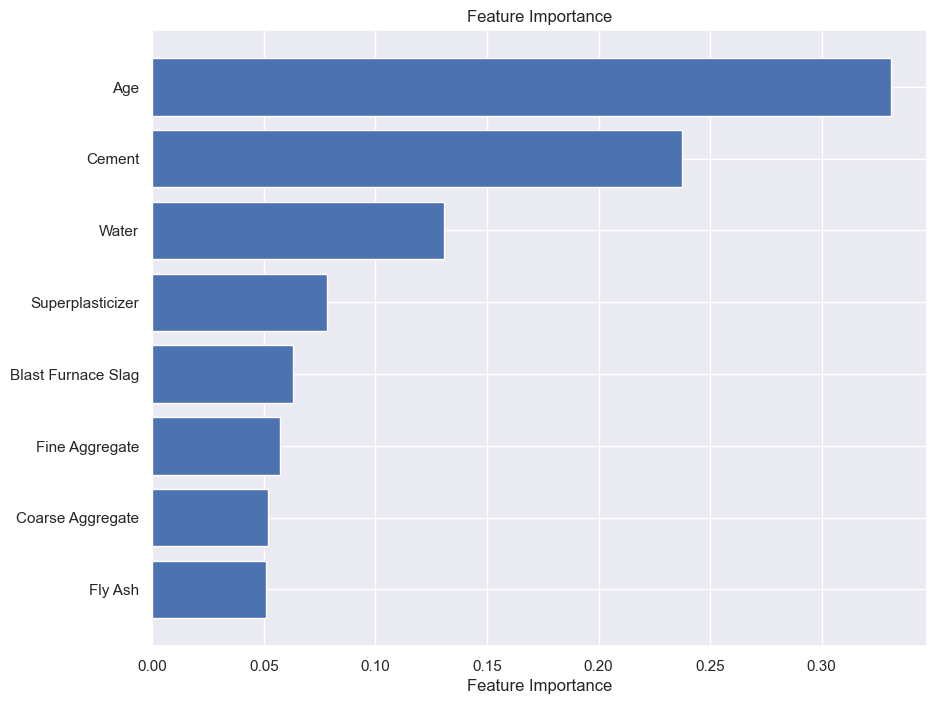

In [95]:
# Feature importance
importance = rf.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importance)
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()


### Performance on Test Data

In [96]:

y_pred=rf.predict(X_test)


In [97]:
RF_rmse=round(np.sqrt(mean_squared_error(y_test, y_pred)),4)
RF_rmse

5.2909

# Conclusion

## Decision Tree Regression

### What is the best method for choosing the number of max features: Auto, Square Root, or Log2?
Auto

### What is the best value for ccp_alpha (the pruning parameter) from the range of 0-1? How deep is the tree with each alpha value?
Decision tree grid search choose 0 as best cost complexty pruning parameter, i.e didnt prune the tree. 

### What variables are most important? What is the Root Node?
`Cement`, `Age`, `Water` were top 3 important variables. The root node is `Age <21`.



## Random Forest Regression

### What is the optimal number of estimators, up to 100?
Grid search results indicated 100 is the best number of estimators. 

### List the feature importance associated with the final model. What variables are most important?
Top 3 important variables were `Age`, `Cement`, and '`Water`, slightly different order than we had for decision tree. 


## Models Comparison

In [99]:
print('Decision Tree Model Test RMSE is ', DT_rmse)
print('Random Forest Model Test RMSE is ', RF_rmse)
print('Random Forest has outperformed decision tree regressor')

Decision Tree Model Test RMSE is  8.9116
Random Forest Model Test RMSE is  5.2909
Random Forest has outperformed decision tree regressor
